# StackOverflow Tags Prediction without specific packagess

# Outline
- [ 1 - Import the Data](#1)
- [ 2 - Exploring the Data](#2)
  - [ 2.1 - Bag of words](#2.1)
  - [ 2.2 - TF-IDF](#2.2)
  - [ 2.3 - CBOW](#2.3)
    - [ 2.3.1 - Data prepare](#2.3.1)
    - [ 2.3.2 - Train neuron network](#2.3.2)
    - [ 2.3.3 - PCA for plotting results](#2.3.3)
- [ 3 - Model creation and evaluation](#3)    
    

<a name="1"></a>
## 1 - Import the Data

TO DO!!!!

In this section, you will use [`Kaggle Questions csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Questions.csv) to transform the sentences into integers, so they can be fed into the model you will build later on.
[`Kaggle Labled Tags csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Tags.csv)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse as sp_sparse
import re
from numpy import linalg as LA

In [2]:
%timeit
train = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Questions.csv/Questions.csv', encoding = "ISO-8859-1")

In [3]:
y_data = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Tags.csv/Tags.csv', encoding = "ISO-8859-1")

<a name="2"></a>
## 2 - Exploring the Data and prepare data for model

In [4]:
train["Id"].nunique() == len(train) == y_data["Id"].nunique()

True

In [5]:
y_data["Id"].nunique() == len(y_data)

False

In [6]:
y_data = y_data.groupby("Id")["Tag"].apply(list).reset_index()
y_data.head()

,Id,Tag
0,80,"[flex, actionscript-3, air]"
1,90,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,"[sql, asp.net, sitemap]"
3,180,"[algorithm, language-agnostic, colors, color-s..."
4,260,"[c#, .net, scripting, compiler-construction]"


In [7]:
y_data["Id"].nunique() == len(y_data)

True

In [8]:
all_data = train.merge(y_data, how='left', left_on='Id', right_on='Id')
all_data["Tag"].isna().sum()

0

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

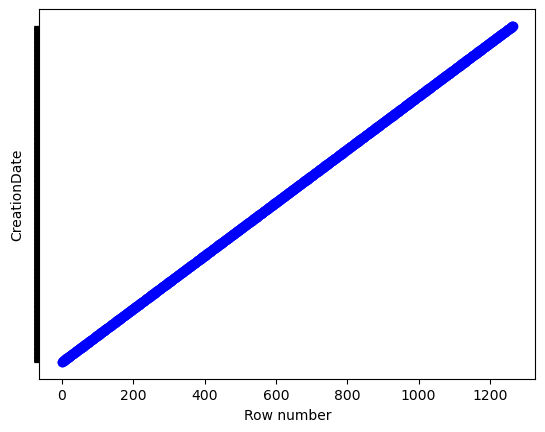

In [10]:
n=1000

fig,ax = plt.subplots(1)
ax.plot(range(len(all_data["CreationDate"][::n])), all_data["CreationDate"][::n], 'o', color='blue')
ax.set_ylabel('CreationDate')
ax.set_xlabel('Row number')

# Turn off tick labels
ax.set_yticklabels([])
plt.show()

In [12]:
def train_test_splitting(X, y, test_size, shuffle=True):
    length_data = len(X)
    test_len = int(length_data*test_size)
    train_len = length_data - test_len
    if shuffle:
        index = np.random.permutation(length_data)
        a = index[:5]
    else:
        index = np.arange(length_data)
    train_index = index[:train_len]
    test_index = index[train_len:]

    return X[train_index],X[test_index],y[train_index],y[test_index], a

In [13]:
np.random.seed(0)
X_train,X_test,y_train,y_test,ind = train_test_splitting(all_data["Title"], all_data["Tag"], test_size=0.3 , shuffle=True) 

In [14]:
ind_test = [644395,1133820,168906,459589,1227779]

In [15]:
assert set(ind_test) == set(ind), "Indexes don't match"

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def text_prepare(text):
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [18]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

<a name="2.1"></a>
## 2.1 - Bag of words

In [67]:
def most_common_words(X):
    words_counts = {}
    
    for i in X:
        try:
            for j in i.split():
                words_counts[j] = words_counts.get(j, 0) + 1
        except:
            for j in i:
                words_counts[j] = words_counts.get(j, 0) + 1

    return sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

In [68]:
X_most_common_words, y_most_common_tags  = most_common_words(X_train), most_common_words(y_train)

In [69]:
y_most_common_tags[:5]

[('javascript', 87002),
 ('java', 80461),
 ('c#', 70800),
 ('php', 69331),
 ('android', 63318)]

In [70]:
DICT_SIZE = 5000

In [71]:
words_index = {k: v for k, v in X_most_common_words[:DICT_SIZE]}

In [72]:
dict_index = {k: v for k, v in enumerate(words_index)}
index_dict = {value: key for key, value in dict_index.items()}

In [73]:
def my_bag_of_words(text, words_index, dict_size):

#     words_to_index = {k:num for num,k in enumerate(words_index.keys())}
    ALL_WORDS = words_index.keys()
    result_vector = np.zeros(dict_size)
    for i in text.split():
        if i in ALL_WORDS:
            result_vector[words_to_index[i]] = 1

    return result_vector

In [81]:
X_train_mybag = sp_sparse.vstack([sp_sparse.lil_matrix(my_bag_of_words(text, dict_index, DICT_SIZE)) for text in X_train])

X_test_mybag = sp_sparse.vstack([sp_sparse.lil_matrix(my_bag_of_words(text, dict_index, DICT_SIZE)) for text in X_test])

In [80]:
X_test_mybag

<379264x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

<a name="2.2"></a>
## 2.2 - TF-IDF

 For this approuch we'll create module Tfidf that create a class and make fit, transform tramsformation

In [22]:
import Tfidf as tf

In [26]:
tfidf_obj = tf.TFIDF()
tfidf_obj.fit(X_train)

In [28]:
X_train_tfidf = tfidf_obj.transform(X_train)
X_test_tfidf = tfidf_obj.transform(X_test)
tfidf_vocab = tfidf_obj.get_vocab()

In [29]:
tfidf_index_to_word = {word[0]:index for index,word in enumerate(tfidf_vocab)}

In [30]:
len(X_train)

884952

In [52]:
X_test_tfidf

<379264x163224 sparse matrix of type '<class 'numpy.float64'>'
	with 2091000 stored elements in COOrdinate format>

<a name="2.3"></a>
## 2.3 - CBOW

 For this approuch we'll create two dictionaries to convert all unick words into a number and vise versa. Next we'll create two arres one with context words and another with center, that is what we are going to feed into neuron network. Train simple neuron networt with only 2 layers. As a result we'll get two matrises with trained weights the mean sum of them give us embedings of each word.

<a name="2.3.1"></a>
### 2.3.1 - Data prepare

In [31]:
def add_pad(text, num_of_padding, padding_car):
    text_with_pad = []
    for sent in text:
        sent = (padding_car + " ") * num_of_padding + sent + (" " + padding_car) * num_of_padding
        text_with_pad.append(sent)
    return text_with_pad

In [32]:
def get_dict(text): 
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for sent in text:
        try:
            for word in sent.split():
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
        except:
            for word in sent:
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
    return word2Ind,Ind2word

In [33]:
def get_data_with_window(text, num_neighbor_words, padding = False):
    
    if padding:
        text = add_pad(text, num_neighbor_words, "PAD")
        
    word2Ind, Ind2word = get_dict(text)
    vector_lenght = len(word2Ind)
    count = 0
    for sent in text:
        length = len(sent.split()) - 2*num_neighbor_words
        if length > 0:
            count += length
    X_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    y_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    Y = []
    n = 0
    for row, sent in enumerate(text):
        sent_to_separete = sent.split()
        for i in range(num_neighbor_words, len(sent_to_separete) - num_neighbor_words):
            center_word = sent_to_separete[i]
            context_words = sent_to_separete[(i - num_neighbor_words):i] + sent_to_separete[(i+1):(i+num_neighbor_words+1)]
            y_matrix[n, word2Ind[center_word]] = 1
            Y.append(word2Ind[center_word])
            for con_word in context_words:
                X_matrix[n, word2Ind[con_word]] += 1
            n += 1
    X_matrix = (X_matrix/sp_sparse.lil_matrix.sum(X_matrix, axis = 1)).tolil()
    Y = np.array(Y)
    return X_matrix, Y, word2Ind, Ind2word

In [34]:
X, y, word2Ind, Ind2word  = get_data_with_window(X_train, 2, padding = True)

In [20]:
X.shape, max(Ind2word)

((5078191, 163225), 163224)

<a name="2.3.2"></a>
### 2.3.2 - Train neuron network

In [33]:
import NN_for_CBOW as NN

In [48]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 1, batchsize = 100, initialization = "xavier")

done 2.0% of epoch - 0, loss: 11.87303365617129 
time for 100000 samples: 0:09:00.242900
done 3.9% of epoch - 0, loss: 9.189317101171694 
time for 100000 samples: 0:18:50.386442
done 5.9% of epoch - 0, loss: 9.01009113545022 
time for 100000 samples: 0:43:16.708946
done 7.9% of epoch - 0, loss: 8.84581000375355 
time for 100000 samples: 1:17:40.290836
done 9.8% of epoch - 0, loss: 8.458349133305855 
time for 100000 samples: 1:39:00.345942
done 11.8% of epoch - 0, loss: 8.444766678875077 
time for 100000 samples: 1:47:34.238072
done 13.8% of epoch - 0, loss: 7.962139519672881 
time for 100000 samples: 2:11:20.780718
done 15.8% of epoch - 0, loss: 8.462100994330601 
time for 100000 samples: 2:50:55.336606
done 17.7% of epoch - 0, loss: 8.548453941561947 
time for 100000 samples: 2:59:46.559325
done 19.7% of epoch - 0, loss: 8.399035070298059 
time for 100000 samples: 3:08:42.295300
done 21.7% of epoch - 0, loss: 8.415181703473326 
time for 100000 samples: 3:17:59.496623
done 23.6% of epo

In [76]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 4, batchsize = 100, \
                                initialization = "custom",weights_1 = W_1, weights_2 = W_2)

done 2.0% of epoch - 0, loss: 9.409370113725881 
 time for 100000 samples: 0:06:15.776176
done 3.9% of epoch - 0, loss: 8.739939438338556 
 time for 100000 samples: 0:12:22.916958
done 5.9% of epoch - 0, loss: 8.25776119276121 
 time for 100000 samples: 0:18:25.489723
done 7.9% of epoch - 0, loss: 8.23271822314867 
 time for 100000 samples: 0:24:30.342833
done 9.9% of epoch - 0, loss: 8.445524782753651 
 time for 100000 samples: 0:30:30.936172
done 11.8% of epoch - 0, loss: 8.117662160451824 
 time for 100000 samples: 0:36:36.671185
done 13.8% of epoch - 0, loss: 8.36204527775428 
 time for 100000 samples: 0:42:37.673783
done 15.8% of epoch - 0, loss: 8.242961961072115 
 time for 100000 samples: 0:48:35.373248
done 17.7% of epoch - 0, loss: 8.084340025561714 
 time for 100000 samples: 0:54:30.845691
done 19.7% of epoch - 0, loss: 8.37243577483956 
 time for 100000 samples: 1:00:26.359755
done 21.7% of epoch - 0, loss: 8.106786033534462 
 time for 100000 samples: 1:06:16.936000
done 23.

KeyboardInterrupt: 

In [36]:
W_1 = np.array(pd.read_csv("weights_1.csv", header=None))
W_2 = np.array(pd.read_csv("weights_2.csv", header=None))

In [37]:
word_embedings = (W_1 + W_2.T)/2

In [ ]:
embedings_for_model = np.mean(word_embedings[1:],axis = 1)

<a name="2.3.3"></a>
### 2.3.3 - PCA for plotting results

In [38]:
def pca(data, number_components):
    if number_components<=data.shape[1]:
        cov_mat = np.cov(data.T)
        eigenvalues, eigenvectors = LA.eig(cov_mat)
        two_vectors = eigenvectors[np.argsort(eigenvalues)[:number_components]]
        return data@two_vectors.T
    else:
        raise ValueError("Number of components > data dimention")

In [40]:
data_form_pca.shape

(163224, 2)

In [42]:
data_form_pca = pca(word_embedings[1:], 2)
Ind2word_no_pad = {k:v for k,v in enumerate(list(Ind2word.values())[1:])}
word2Ind_no_pad = {k:v for v,k in Ind2word_no_pad.items()}

In [43]:
def plot_some_data(names):
    num_of_rows = list( map(word2Ind_no_pad.get, names) )
    data_to_plot = data_form_pca[num_of_rows]
    A = [i[0] for i in data_to_plot]
    B = [i[1] for i in data_to_plot]
    fig, ax = plt.subplots()
    ax.scatter(A, B)

    for i, txt in enumerate(names):
        ax.annotate(txt, (A[i], B[i]))

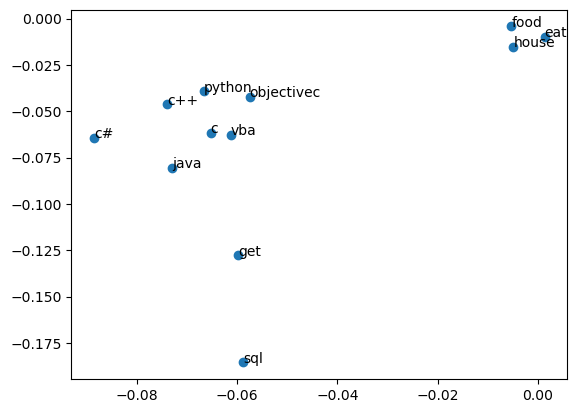

In [44]:
plot_some_data(['python','c','c++','c#','objectivec','sql','vba','get','java','eat','food','house'])

<a name="3"></a>
## 3 - Model creation and evaluation

In [46]:
import Binarizer as binar

In [47]:
bnr = binar.Binarizer()
bnr.fit(y_train)
y_train_mat = bnr.transform(y_train)
y_test_mat = bnr.transform(y_test)

In [127]:
from importlib import reload
reload(binar)

<module 'Binarizer' from '/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Binarizer.py'>

In [49]:
y_train_mat.shape

(884952, 34688)

In [53]:
import Logistic_Reg as LR
Log_reg = LR.MyLogisticRegression(learning_rate = 1, num_iterations = 2000)

<a name="3.1"></a>
## 3.1 - BOW evaluation

<a name="3.2"></a>
## 3.2 - Tfidf evaluation

<a name="3.3"></a>
## 3.3 - CBOW evaluation

In [78]:
X_train_mybag.astype(float)

<884952x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [64]:
y_train_mat.T[0].shape

(884952,)

In [54]:
X_tr = np.array([[5,6,1,3,7,4,10,1,2,0,5,3,1,4],[1,2,0,2,3,3,9,4,4,3,6,5,3,7]]).T
Y_tr = np.array([[0,0,0,0,0,0,0,1,1,1,1,1,1,1]]).T
X_ts  = np.array([[2,3,3,3,2,4],[1,1,0,7,6,5]]).T
Y_ts  = np.array([[0,0,0,1,1,1]]).T

In [79]:
Log_reg.fit(X_train_mybag.astype(float), y_train_mat.T[0])

TypeError: loop of ufunc does not support argument 0 of type csr_matrix which has no callable exp method

In [56]:
Log_reg.predict(X_ts)

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.]])

In [38]:
>>> import numpy as np
>>> from sklearn.datasets import make_multilabel_classification
>>> from sklearn.multioutput import MultiOutputClassifier
>>> from sklearn.linear_model import LogisticRegression


In [39]:
>>> X, y = make_multilabel_classification(n_classes=3, random_state=0)


In [45]:
>>> clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
>>> clf.predict(X[-2:])

array([[1, 1, 1],
       [1, 0, 1]])

In [43]:
mlb_1 = MultiLabelBinarizer()
Y_1 = mlb_1.fit_transform(y_train_text_1)

((100, 20), (100, 3))

In [46]:
y[-2:]

array([[1, 1, 1],
       [1, 0, 1]])